In [1]:
from general import *
from classes import LIF

create_folder_if_not_exists('images')
create_folder_if_not_exists('images/motion_neuron')
create_folder_if_not_exists('results')

Folder 'images' already exists.
Folder 'images/motion_neuron' already exists.
Folder 'results' already exists.


In [2]:
with open('temp_data/spike_sensory', 'rb') as file:
    spike_sensory = np.load(file) 
    
time = np.linspace(0, constants['T_TOTAL'], num=constants['N_STEPS'])

motion_parameters = {'tau': 5e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': 2 * constants['N_ANGLES'] * parameters['N_HAIRS'], 'w': 10.5e-3,
                     'N_input': 1, 'dt': constants['dt'], 'refrac': 0}

motion_combine_parameters = {'tau': 5e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': 2 * constants['N_ANGLES'], 'w': 30e-3,
                             'N_input': parameters['N_HAIRS'], 'dt': constants['dt'], 'refrac': 0}

motion_neuron = LIF(motion_parameters)
motion_neuron.initialize_state()

motion_neuron_combine = LIF(motion_combine_parameters)
motion_neuron_combine.initialize_state()

spike_motion_inter = np.empty((constants['N_STEPS'], motion_parameters['n']), dtype=np.uint8)
spike_motion = np.empty((constants['N_STEPS'], 2 * constants['N_ANGLES'], parameters['N_SIMULATIONS']), dtype=np.uint8)

In [3]:
for k in tqdm(range(parameters['N_SIMULATIONS'])):   
    spike_sensory_k = spike_sensory[:, :, k]
    for i in range(constants['N_STEPS']):
        _, spike_motion_inter[i, :] = motion_neuron.forward(spike_sensory_k[i, :])
        
        _, spike_motion[i, :, k]= motion_neuron_combine.forward(spike_motion_inter[i, :].reshape(2*constants['N_ANGLES'], parameters['N_HAIRS']))
        
        
        
        
        
        #spike_motion[i, :, k] = np.sum(spike_motion_inter[i, :, k].reshape(2*constants['N_ANGLES'], parameters['N_HAIRS']), axis=1)
        #spike_motion[i, :, k][spike_motion[i, :, k] > 1 ] = 1

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
with open('temp_data/spike_motion', 'wb') as file:
    np.save(file, spike_motion)

[0.07136271909719942, 0.3239833297172885]


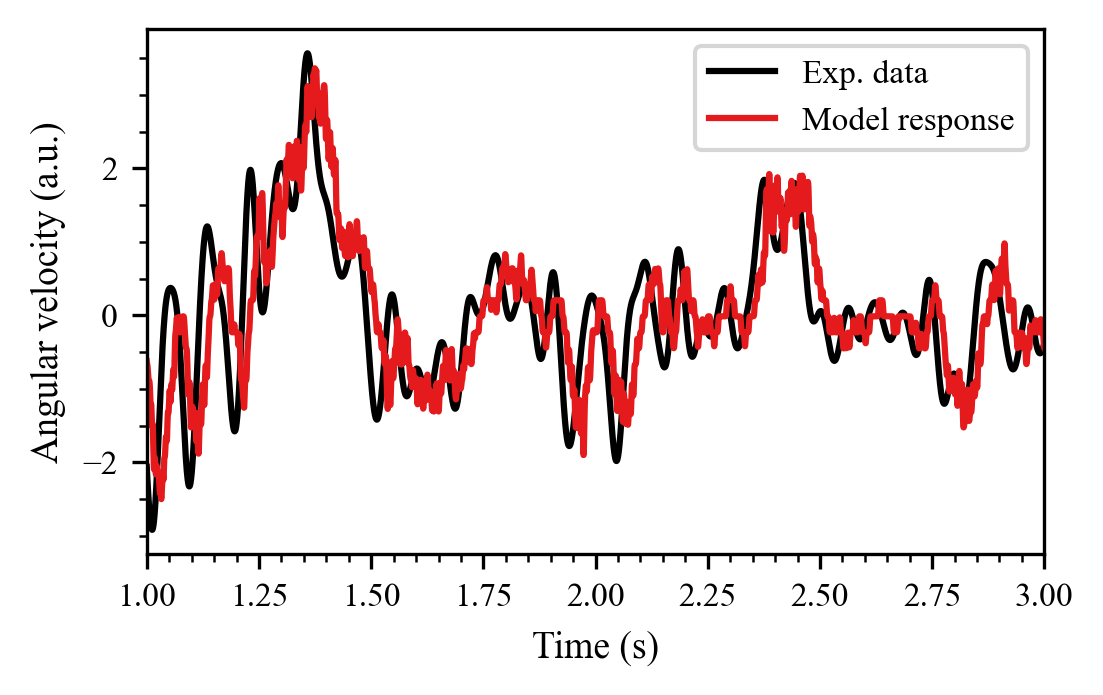

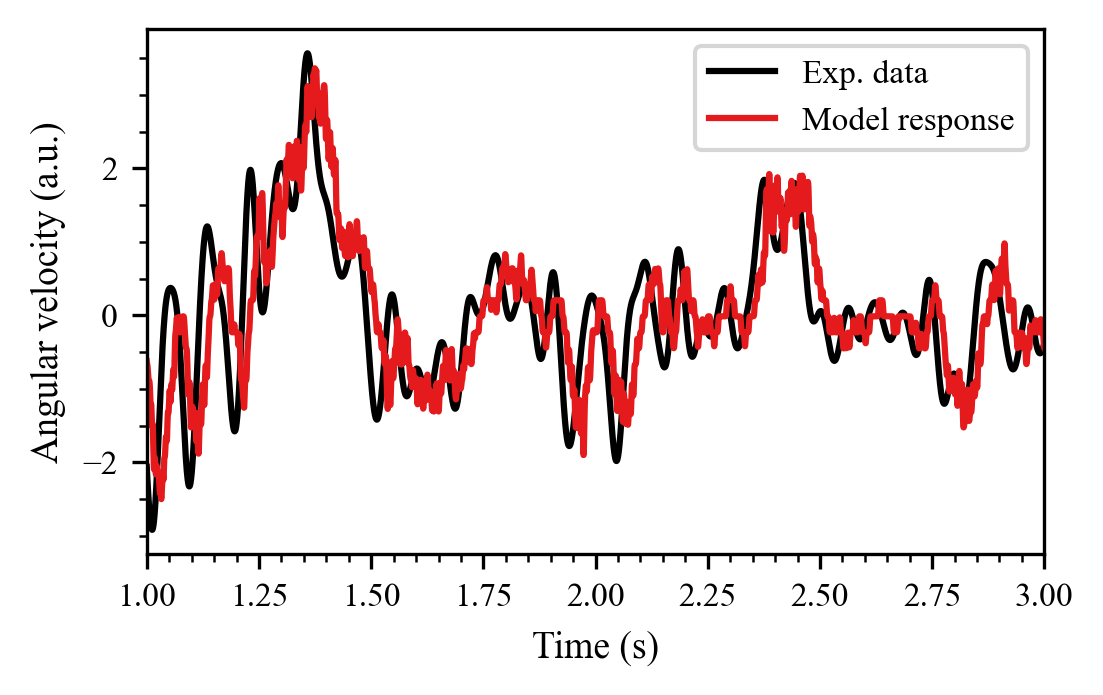

In [5]:
with open('temp_data/joint_angles_' + parameters['joint_string'], 'rb') as file:
    joint_angles = np.load(file)

delta_1 = int(0.025/constants['dt'])
delta_2 = 1

MSEs = []

for delta in [delta_1, delta_2]:
    MSE = np.zeros((parameters['N_SIMULATIONS'], constants['N_ANGLES']))
    
    for k, m in np.ndindex(parameters['N_SIMULATIONS'], constants['N_ANGLES']):
        firing_rate_down = get_firing_rate_convolve(spike_motion[:, 0 + 2*m, k], constants['dt'], t=0.01, nan_bool=False)
        firing_rate_up = get_firing_rate_convolve(spike_motion[:, 1 + 2*m, k], constants['dt'], t=0.01, nan_bool=False)
        
        combined_firing_rate = firing_rate_up - firing_rate_down
        
        combined_firing_rate_norm = zscore.zscore(combined_firing_rate)
        joint_angle_norm = zscore.zscore(np.diff(joint_angles[:, m, k]) / constants['dt'])
        
        MSE[k, m] = np.mean((combined_firing_rate_norm[2001:] - joint_angle_norm[2000-delta: -delta])**2)   
        if k + m == 0:
            fig, ax = plt.subplots()
    
            ax.plot(time[:-1], joint_angle_norm, color='black', label='Exp. data')
            ax.plot(time, combined_firing_rate_norm, color=custom_colors[0], label = 'Model response')
            
            ax.set_xlim([1, 3])
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Angular velocity (a.u.)")
            ax.minorticks_on()
            ax.legend()
            
            fig.tight_layout(pad=parameters['pad'])
            fig.savefig('images/motion_neuron/combined_motion_din_.png')
       
    MSEs.append(np.mean(MSE))
    
print(MSEs)

In [6]:
with open('temp_data/joint_angles_' + parameters['joint_string'], 'rb') as file:
    joint_angles = np.load(file) 
     
joint_velocity = np.diff(joint_angles[:, :, :parameters['N_SIMULATIONS']], axis=0)
joint_velocity_up = np.heaviside(joint_velocity, 0)
joint_velocity_down = 1 - joint_velocity_up

true_positive, false_positive, _, _ = get_confusion_matrix(spike_motion[1:, 1::2], joint_velocity_up)
true_negative, false_negative, _, _ = get_confusion_matrix(spike_motion[1:, 0::2], joint_velocity_down)

statistical_data = get_statistics(true_positive, true_negative, false_positive, false_negative)

statistical_data = statistical_data + MSEs


statistical_data_string = ['true positive', 'true negative', 'false positive', 'false negative', 'positives', 'negatives', 'total', 'MCC', 'accuracy', 'TPR', 'TNR', 'MSE_corrected', 'MSE_not_corrected']

table = {'value': statistical_data}
df = pd.DataFrame(data=table, index=statistical_data_string)
df.to_csv('results/motion_accuracy_table.csv')

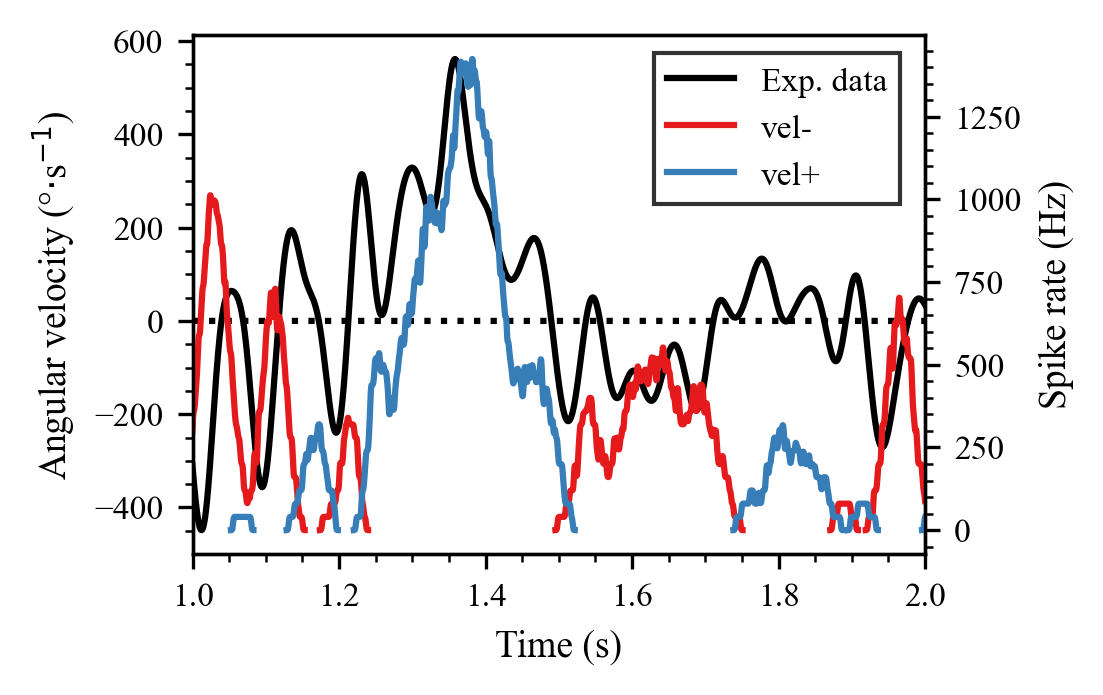

In [7]:
joint_angles = joint_angles[:, :, 0]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

firing_rate_down = get_firing_rate_convolve(spike_motion[:, 0, 0], constants['dt'], t=0.025)
firing_rate_up = get_firing_rate_convolve(spike_motion[:, 1, 0], constants['dt'], t=0.025)

ax1.plot(time[1:], np.diff(joint_angles[:, 0]) / constants['dt'], color='black', linestyle=custom_linestyles[0], label='Exp. data')
ax2.plot(time, firing_rate_down, color=custom_colors[0], label='vel-')
ax2.plot(time, firing_rate_up, color=custom_colors[1], label='vel+')
ax1.plot(time, np.full(time.size, 0), color='black', linestyle='dotted')

ax1.set_xlim([1, 2])
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Angular velocity (°$\cdot$s$^{-1}$)")
ax2.set_ylabel("Spike rate (Hz)")

ax1.minorticks_on()
ax2.minorticks_on()

fig.legend(loc='upper left', fancybox=False, edgecolor='black', bbox_to_anchor=[0.58, 0.97])

fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/motion_neuron/motion_binary.png')

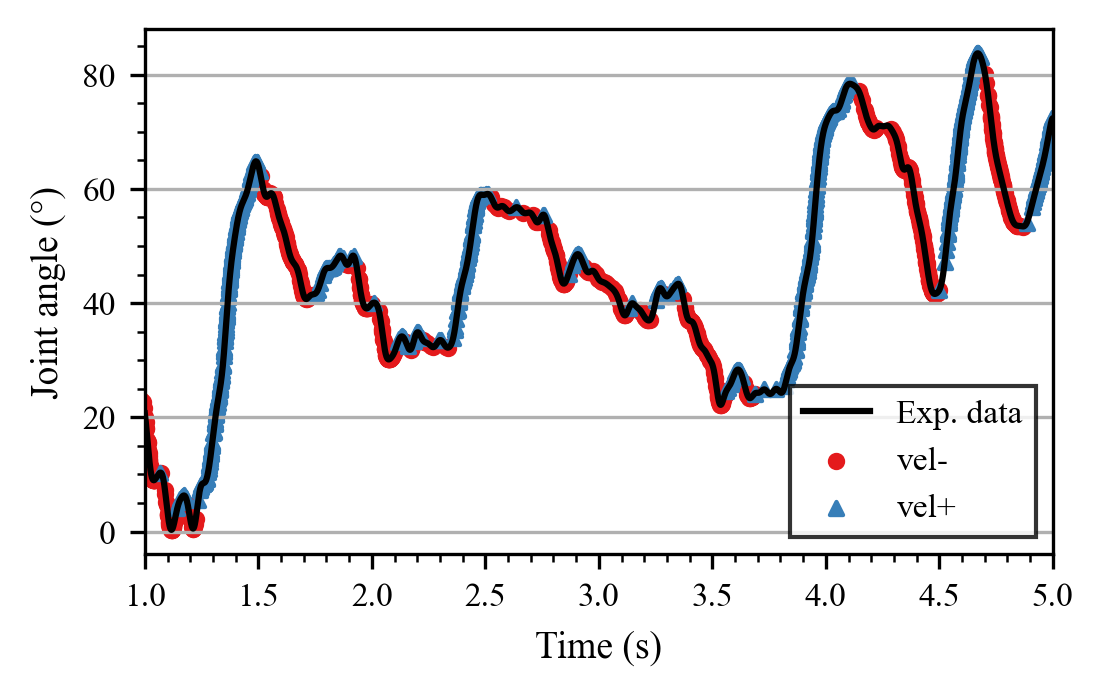

In [8]:
spike_motion = spike_motion.astype(np.float32)
spike_motion[spike_motion == 0] = np.nan

fig, ax = plt.subplots()

plt.plot(time, joint_angles[:, 0], color='black')
plt.scatter(time, joint_angles[:, 0] * spike_motion[:, 0, 0], color=custom_colors[0], marker=custom_markers[0], s=10)
plt.scatter(time, joint_angles[:, 0] * spike_motion[:, 1, 0], color=custom_colors[1], marker=custom_markers[1], s=10)

ax.set_xlim([1, 5])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Joint angle (°)")

ax.grid(axis='y', zorder=0)

ax.minorticks_on()

ax.legend(['Exp. data', 'vel-', 'vel+'], fancybox=False, edgecolor='black')

fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/motion_neuron/movement_interneuron_network.png')

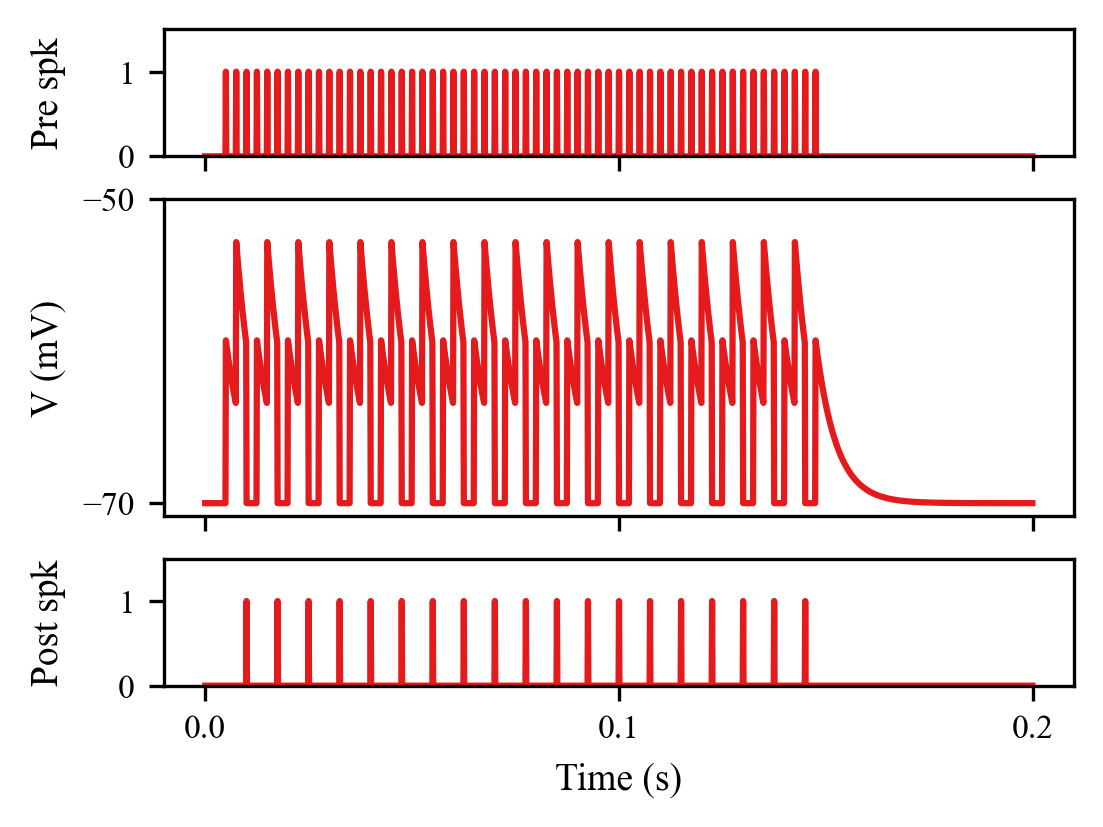

In [9]:
fig, [ax, ax2, ax3] = plt.subplots(3, figsize=(3.75*0.95, 1.2*0.95*3.75/1.61803398875), gridspec_kw={'height_ratios': [1, 2.5, 1]}, sharex='all')
plt.subplots_adjust(wspace=0, hspace=0.05)

motion_parameters = {'tau': 5e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': 1, 'w': 10.7e-3,
                     'N_input': 1, 'dt': 0.0001, 'refrac': 0}

motion_neuron = LIF(motion_parameters)

motion_neuron.initialize_state()

input = np.zeros(2000)
input[50:1500][::25] = 1

voltage, spikes, time = np.zeros(input.size), np.zeros(input.size), np.zeros(input.size)

for i in range(input.size):
    voltage[i], spikes[i] = motion_neuron.forward(input[i])
    time[i] = i*0.0001 
    
ax.plot(time, input, color=custom_colors[0])    

ax.set_ylabel("Pre spk")
ax.set_yticks([0, 1])
ax.set_xticks([0, 0.1, 0.2])
ax.set_ylim(0, 1.5)

ax2.plot(time, voltage*1000, color=custom_colors[0])

ax2.set_ylabel("V (mV)")
ax2.set_yticks([-70, -50])

ax3.plot(time, spikes, color=custom_colors[0])

ax3.set_ylabel("Post spk")
ax3.set_yticks([0, 1])
ax3.set_xlabel("Time (s)")
ax3.set_ylim(0, 1.5)

fig.align_ylabels([ax, ax2, ax3])                   
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/motion_neuron/LIF_dynamics.png')

In [10]:
class HairField:
    def __init__(self, parameters):
        self.N_hairs = parameters['N_hairs']
        self.max_joint_angle = parameters['max_joint_angle']
        self.max_list = parameters['max_joint_angle']
        self.min_joint_angle = parameters['min_joint_angle']
        self.min_list = parameters['min_joint_angle']
        self.max_angle = parameters['max_angle']
        self.overlap = parameters['overlap']
        self.receptive_field = None

    def get_receptive_field(self):
        rf = (self.max_joint_angle - self.min_joint_angle) / self.N_hairs
        rf = (1-self.overlap/(self.max_joint_angle - self.min_joint_angle))*rf

        receptive_min = np.linspace(self.min_joint_angle, self.min_joint_angle + rf*(self.N_hairs - 1),
                                    num=self.N_hairs)

        receptive_max = np.linspace(self.max_joint_angle - rf*(self.N_hairs - 1), self.max_joint_angle,
                                    num=self.N_hairs)

        self.receptive_field = np.stack((receptive_min, receptive_max))
        
        
    def get_double_receptive_field(self):
        self.get_receptive_field()

        rf1 = -self.receptive_field.copy() + self.max_joint_angle + self.min_joint_angle

        self.receptive_field = np.hstack((rf1, self.receptive_field))
        self.N_hairs = 2 * self.N_hairs
        
    
    def reset_max_min(self, i):
        self.max_joint_angle = self.max_list[i]
        self.min_joint_angle = self.min_list[i]


    def get_hair_angle(self, x):
        min_rf = self.receptive_field[0, :]
        slope = self.max_angle / (self.receptive_field[1, :] - self.receptive_field[0, :])

        slope, min_rf, x = np.tile(slope, (x.size, 1)), np.tile(min_rf, (x.size, 1)), np.tile(x, (self.N_hairs, 1)).T

        out = np.clip(slope * (x - self.receptive_field[0, :]), 0, 90)

        return out

In [11]:
class SensoryNeuron:
    NeuronState = namedtuple('NeuronState', ['V', 'w', 'spk'])

    def __init__(self, parameters):
        super(SensoryNeuron, self).__init__()
        self.C = parameters['C']
        self.g_L = parameters['g_L']
        self.E_L = parameters['E_L']
        self.DeltaT = parameters['DeltaT']
        self.a = parameters['a']
        self.V_T = parameters['V_T']
        self.tau_W = parameters['tau_W']
        self.b = parameters['b']
        self.V_R = parameters['V_R']
        self.V_cut = parameters['V_cut']
        self.n = parameters['n']
        self.dt = parameters['dt']
        self.state = None

    def initialize_state(self):
        self.state = None

    def forward(self, input):
        if self.state is None:
            self.state = self.NeuronState(V=np.linspace(self.E_L, self.E_L+10e-3, self.n),
                                          w=np.zeros(self.n),
                                          spk=np.zeros(self.n))
        V = self.state.V
        w = self.state.w
        I = input
        
        V += (self.g_L * (self.E_L - V) + self.g_L * self.DeltaT * np.exp(
            (V - self.V_T) / self.DeltaT) - w + I) * self.dt / self.C

        spk = np.heaviside(V - self.V_cut, 0)
        
        V = (1 - spk) * V + spk * self.V_R
        
        w += spk * self.b
        w += (self.a * (V - self.E_L) - w) * self.dt / self.tau_W

        self.state = self.NeuronState(V=V, w=w, spk=spk)

        return V, spk

0it [00:00, ?it/s]

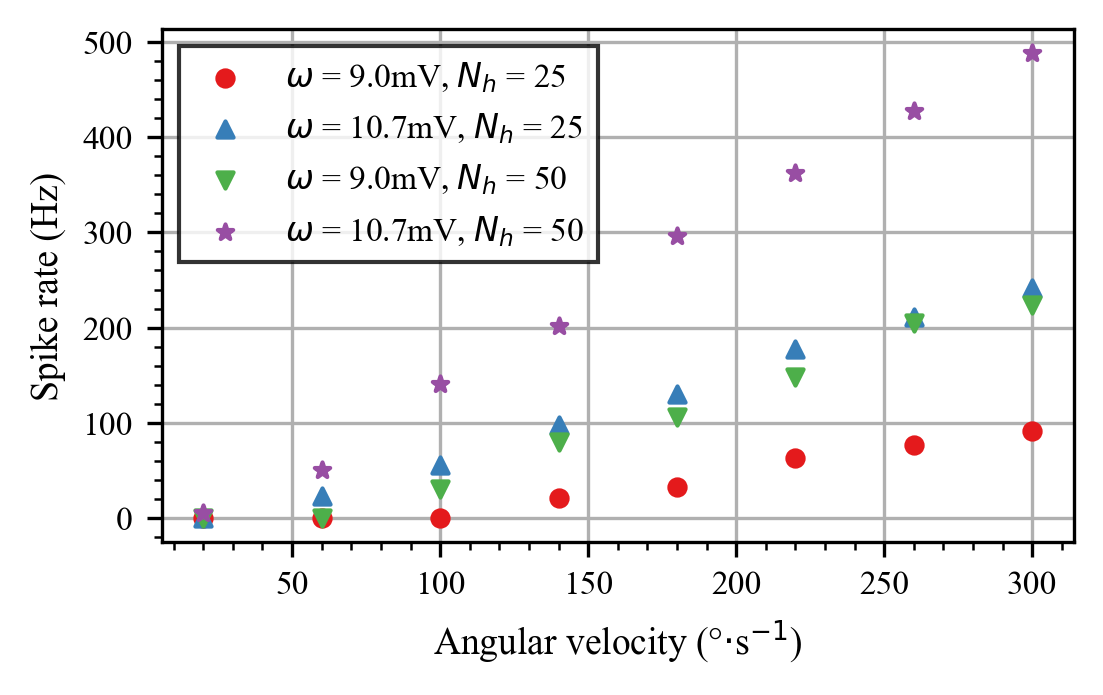

In [12]:
N_HAIRS_LIST = np.array([25, 50])
WEIGHT_LIST = np.array([9e-3, 10.7e-3])
N_SPEEDS = 8
T_TOTAL = 20
N_STEPS = int(T_TOTAL/constants['dt'])

time = np.linspace(0, constants['T_TOTAL'], num=constants['N_STEPS'])
speeds = np.linspace(20, 300, num=N_SPEEDS)
ramp = (180 / (speeds * constants['dt'])).astype(int)

spike_motion = np.zeros((N_STEPS, N_SPEEDS))
spike_rates = np.zeros((N_HAIRS_LIST.size, WEIGHT_LIST.size, N_SPEEDS))

fig, ax = plt.subplots()

index = 0

for l,m in tqdm(np.ndindex(N_HAIRS_LIST.size, WEIGHT_LIST.size)):
    
    parameters_hair_field = {'N_hairs': N_HAIRS_LIST[l], 'max_joint_angle': 180, 'min_joint_angle': 0, 'max_angle': 90, 'overlap': 4}
    
    sensory_parameters = {'C': 200e-12, 'g_L': 2e-9, 'E_L': -70e-3, 'DeltaT': 2e-3, 'a': 2e-9, 'V_T': -50e-3,
                          'tau_W': 50e-3, 'b': 264e-12, 'V_R': -70e-3, 'V_cut': -40e-3, 'n': N_HAIRS_LIST[l], 'dt': constants['dt']}
    
    motion_parameters = {'tau': 5e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': N_HAIRS_LIST[l], 'w': WEIGHT_LIST[m],
                         'N_input': 1, 'dt': constants['dt'], 'refrac': 0}
    
    hair_field = HairField(parameters_hair_field)
    hair_field.get_receptive_field()
    
    motion_neuron = LIF(motion_parameters)
    motion_neuron.initialize_state()
    
    sensory_neuron = SensoryNeuron(sensory_parameters)
    sensory_neuron.initialize_state()
    
    for j in range(N_SPEEDS):
        t1 = np.linspace(0, 180, num=ramp[j])
        t2 = np.linspace(180, 180, num=N_STEPS - ramp[j])
        ramp_angles = np.concatenate((t1, t2))
        hair_angles = hair_field.get_hair_angle(ramp_angles) / 18e9
        
        for i in range(N_STEPS):
            _, spike_1 = sensory_neuron.forward(hair_angles[i])

            _, spike_2 = motion_neuron.forward(spike_1)
            
            spike_motion[i, j] = np.sum(spike_2)
            
           
        spike_rates[l, m, j] = np.sum(spike_motion[:ramp[j], j]/(ramp[j]*constants['dt']))

    ax.scatter(speeds, spike_rates[l, m, :], color=custom_colors[index], marker=custom_markers[index], s = 15,
               label=r'$\omega$ = ' + str(WEIGHT_LIST[m] * 1000) + 'mV, $N_{h}$ = ' + str(N_HAIRS_LIST[l]), zorder=2)
    
    index += 1
    
    
ax.set_xlabel(r"Angular velocity (°$\cdot$s$^{-1}$)")
ax.set_ylabel("Spike rate (Hz)")

ax.legend(loc='upper left', fancybox=False, edgecolor='black')

ax.minorticks_on()
ax.grid(zorder=0)

fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/motion_neuron/motion_linearity.png')